## Imports

In [6]:
# main libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import Markdown

In [22]:
# geo libraries

import geopandas as gpd
import geoplot as gplt
import plotly.graph_objects as go
import networkx as nx
import pygraphviz
from pyvis.network import Network

ModuleNotFoundError: No module named 'geoplot'

# Week 1

,geo,TIME_PERIOD,OBS_VALUE
139,DE,2024,83456045
274,FR,2024,68467362
367,IT,2024,58971230
229,ES,2024,48619695
517,PL,2024,36620970
549,RO,2024,19067576
492,NL,2024,17942942
53,BE,2024,11817096
112,CZ,2024,10900555
537,PT,2024,10639726


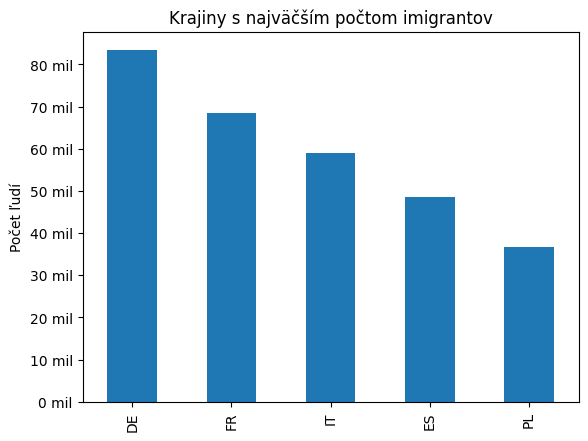

In [54]:
url = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/GeneralEU1.csv"

# Чтение CSV файла
df = pd.read_csv(url).drop(['STRUCTURE','STRUCTURE_ID', 'CONF_STATUS', 'OBS_FLAG', 'freq'], axis=1)

# Отображаем данные
df_without_genders = df.groupby(['geo', 'TIME_PERIOD'])['OBS_VALUE'].sum().reset_index()
df_sorted_by_number_immigrates = df_without_genders[df_without_genders['TIME_PERIOD'] == 2024].sort_values(by="OBS_VALUE", ascending=False)
display(df_sorted_by_number_immigrates)
plot_for_number_immigrates = df_sorted_by_number_immigrates[:5].plot(x='geo',
                                                                     y='OBS_VALUE',
                                                                     kind='bar',
                                                                     ylabel='Počet ľudí',
                                                                     xlabel='',
                                                                     title='Krajiny s najväčším počtom imigrantov',
                                                                     legend=False)
plot_for_number_immigrates.ticklabel_format(style='plain', axis='y')
plot_for_number_immigrates.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x/1_000_000:g} mil"))
#sns.barplot(data=df_sorted_by_number_immigrates[:5], x='OBS_VALUE', y='geo')